# Full Upstream Background Estimate
$$N_{ups}=\sum_i N_i^{C}f_{CDA}^iP_i^{mismatch}$$

In [9]:
import numpy as np
import uproot as up
import hist
from hist import Hist
import boost_histogram as bh
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep
hep.style.use(hep.style.ROOT)

## Calculating $P^{mismatch}$

In [34]:
dens = [] # Denominator histograms (K2piNorm selection but K-pi matching just cda < 4 mm)
nums = [] # Numerator histograms (as above but passing full K-pi matching)
with up.open("./data/NoVC/K2piNorm_2022_t0.143.x_pmismatch_XGBNoVC_VariableThresh.root:K2piNormAnalysis") as f:
    h_tot_den = f["den_ngtk_vs_dTplus_p0"].to_hist()[:,0:0.8j]
    for i in range(0, 40): # Made in 1 mm bins of CDA, we average them
        # This is done because CDA in K2piNorm falls off sharply after 4 mm but ~flat for upstream
        dens.append(f[f"den_ngtk_vs_dTplus_p{i}"].to_hist()[:,0:0.8j])
        nums.append(f[f"num_ngtk_vs_dTplus_p{i}"].to_hist()[:,0:0.8j])
        if i > 0:
            h_tot_den = h_tot_den + f[f"den_ngtk_vs_dTplus_p{i}"].to_hist()[:,0:0.8j]

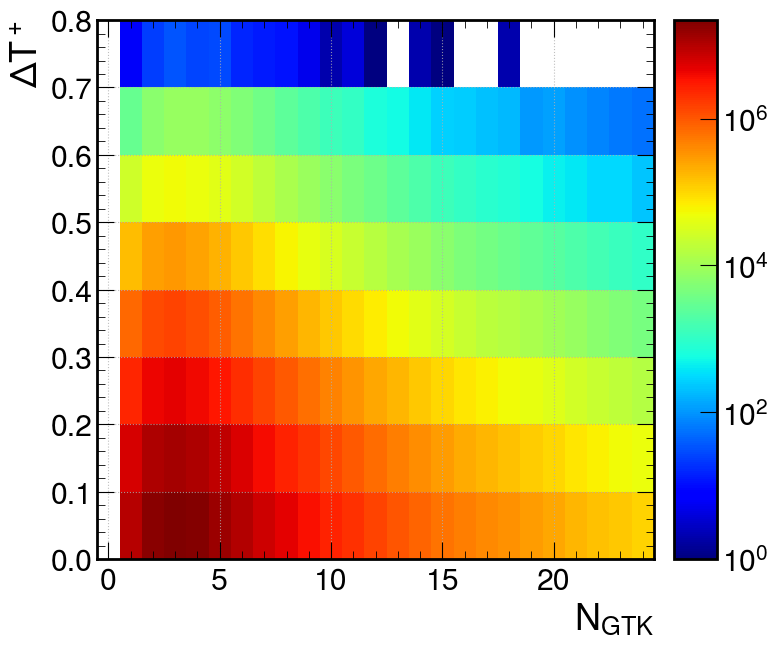

In [19]:
plt.figure(figsize=(8,7))
h_tot_den.plot(cmap="jet", norm=LogNorm())
plt.xlabel(r"$N_{GTK}$")
plt.ylabel(r"$\Delta T^+$")
plt.grid()
plt.show()

In [35]:
def divide_histograms(num, den):
    num_values = num.values()
    den_values = den.values()
    ratio = num_values / den_values
    # Replace NaNs with just zeros
    ratio = np.nan_to_num(ratio, nan=0)
    return ratio

In [36]:
# Entire upstream background is calculated as the sum across momentum, delta(T+) and N(GTK) bins
ratios = np.array([divide_histograms(n, d) for n, d in zip(nums, dens)])
ratios.shape

/var/folders/vr/fcpvsfqx4lvgx3dffz044w2m0000gn/T/ipykernel_1009/3350441520.py:4: RuntimeWarning: invalid value encountered in divide
  ratio = num_values / den_values


(40, 25, 8)

In [37]:
pmismatch_avg = np.mean(ratios, axis=0)
pmismatch_avg.shape

(25, 8)

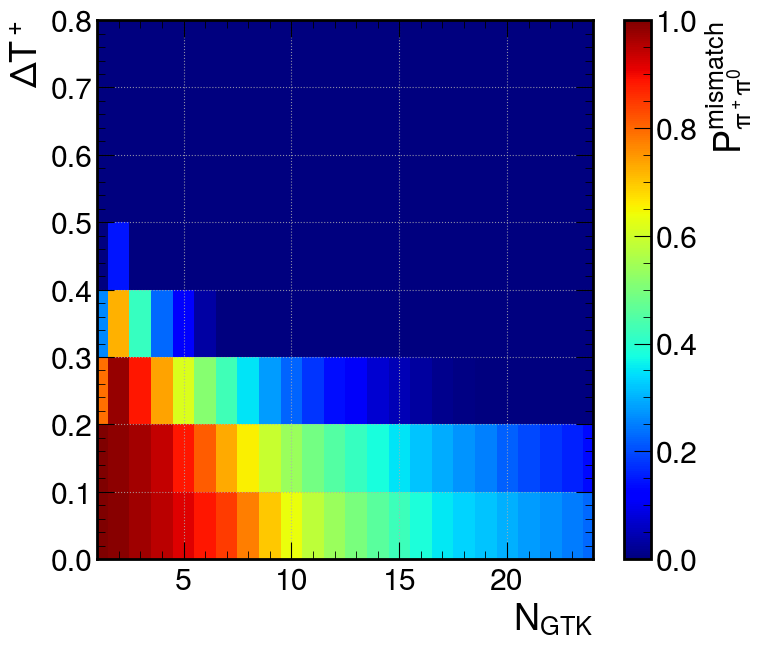

In [33]:
plt.figure(figsize=(8,7))
plt.imshow(pmismatch_avg.T, cmap='jet', aspect="auto", origin="lower")
plt.colorbar(label=r'$P^{mismatch}_{\pi^+\pi^0}$')
plt.xlabel(r"$N_{GTK}$")
plt.ylabel(r"$\Delta T^+$")
plt.xlim(1, 24)
plt.yticks(ticks=np.arange(0, 9, 1) - 0.5, labels=np.arange(0, 9, 1) / 10)
plt.grid()
plt.show()

## Calculating $f_{CDA}$

In [6]:
with up.open("./data/BBFails/Data_2022_Validation_NewBB_WithANTI0Ups_Static.root:PNNAnalysis") as f:
    cda_time_relax = f["sampleC_RelaxTime_CDA"].to_hist()[::bh.rebin(4)]
    cda_time_relax_xgb = f["sampleCXGB_RelaxTime_CDA"].to_hist()[::bh.rebin(4)]

    cda_bb_relax = f["sampleC_RelaxBB_CDA"].to_hist()[::bh.rebin(4)]
    cda_bb_relax_xgb = f["sampleCXGB_RelaxBB_CDA"].to_hist()[::bh.rebin(4)]

    sc = f["sampleC_region"].to_hist()
    sc_xgb = f["sampleCxgb_region"].to_hist()

    sig = f["signal_region"].to_hist()
    sig_xgb = f["signalxgb_region"].to_hist()

    hs = f[f"sampleC_sr_ngtk_v_dtplus"].to_hist()
    hx = f[f"sampleCxgb_sr_ngtk_v_dtplus"].to_hist()

with up.open("./data/NoVC/KpinnNoov_Ups_XGBNoVC_VaryThresh.root:PNNAnalysis") as f:
    pnn_region = f["signal_region"].to_hist()
    pnn_xgb_region = f["signalxgb_region"].to_hist()

In [7]:
regions = {
    'sr1': 1, # signal region 1
    'sr2': 2, # signal region 2
    'k2pi': 3, # K2pi background region
    'kmu2': 4, # Kmu2 background region
    'k3pi': 5, # k3pi background region
    'ups': 6, # upstream backgroun region (-ve mm2)
    'cr1': 10,
    'cr2': 20,
    'crmu': 30,
    'crmu1': 31,
    'crmu2': 32,
    'cr3pi': 40,
    'cr3d': 50,
}

In [8]:
sc.values().sum(), sc_xgb.values().sum()

(2342.0, 1778.0)

In [9]:
sc.values()[1] + sc.values()[2], np.sum(sc_xgb.values()[1:3])

(38.0, 15.0)

In [12]:
sig.values()[regions['kmu2']], sig_xgb.values()[regions['kmu2']], 

(25606.0, 23322.0)

In [13]:
sc.values().sum(), sc_xgb.values().sum()

(2342.0, 2139.0)

In [13]:
cda_time_relax.values()

array([ 0., 14., 17., 10., 18.,  8., 11., 11.,  4.,  7.,  1.,  0.])

In [8]:
def get_fcda(h):
    avg = (h.values()[1] + h.values()[2]) / 2
    v = avg / h.values()[1:].sum()
    er = np.sqrt((avg / h.values()[1:].sum()**2) + ((avg * np.sqrt(h.values()[1:].sum())) / h.values()[1:].sum()**2)**2)
    print(f"{v:.3f} +/- {er:.3f}")
    return v, er # Return [0, 4] mm bin over sum of >12 mm

print(get_fcda(cda_time_relax)) # 100 values
print(get_fcda(cda_bb_relax)) # 407 values

print(get_fcda(cda_time_relax_xgb)) # 22 values
print(get_fcda(cda_bb_relax_xgb)) # 224 values

0.153 +/- 0.042
(0.15346534653465346, 0.04186458120679513)
0.184 +/- 0.023
(0.18401937046004843, 0.022968685871525094)
0.222 +/- 0.123
(0.2222222222222222, 0.12283795519834814)
0.227 +/- 0.043
(0.22666666666666666, 0.04305379924733274)


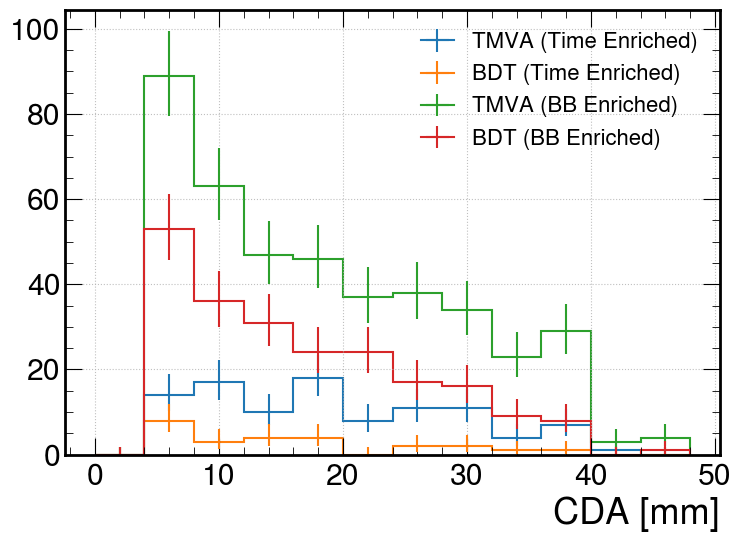

In [20]:
plt.figure(figsize=(8,6))
cda_time_relax.plot(label="TMVA (Time Enriched)")
cda_time_relax_xgb.plot(label="BDT (Time Enriched)")
cda_bb_relax.plot(label="TMVA (BB Enriched)")
cda_bb_relax_xgb.plot(label="BDT (BB Enriched)")
plt.grid()
plt.legend(fontsize=16)
plt.xlabel("CDA [mm]")
plt.tight_layout()
plt.savefig("./plots/fcda_cda_distribution_sampleC_Enriched_tmva_v_bdtANTI0_EnhancedSample.pdf")
plt.show()

In [9]:
x0 = np.mean([get_fcda(cda_time_relax)[0], get_fcda(cda_bb_relax)[0]])
x0

0.153 +/- 0.042
0.184 +/- 0.023


0.16874235849735095

In [10]:
print(get_fcda(cda_time_relax_xgb)[0]) # Only 22 events in this histogram, pretty unreliable
print(get_fcda(cda_bb_relax_xgb)[0]) # 221 events in this histogram, much more reliable

0.222 +/- 0.123
0.2222222222222222
0.227 +/- 0.043
0.22666666666666666


In [11]:
x1 = np.mean([get_fcda(cda_time_relax_xgb)[0], get_fcda(cda_bb_relax_xgb)[0]])
x1

0.222 +/- 0.123
0.227 +/- 0.043


0.22444444444444445

In [19]:
# Calculate error on the mean of these values of F_CDA e(mu) = sqrt((b*e(a))^2 + (a*e(b))**2)
x10 = get_fcda(cda_time_relax_xgb)
x11 = get_fcda(cda_bb_relax_xgb)
ex1 = np.sqrt((x11[0] * x10[1])**2 + (x10[0] * x11[1])**2)
print(f"{x1:.3f} +/- {ex1:.3f}\n")

x00 = get_fcda(cda_time_relax)
x01 = get_fcda(cda_bb_relax)
ex0 = np.sqrt((x01[0] * x00[1])**2 + (x00[0] * x01[1])**2)
print(f"{x0:.3f} +/- {ex0:.3f}")

0.273 +/- 0.126
0.203 +/- 0.030
0.238 +/- 0.027

0.153 +/- 0.042
0.184 +/- 0.023
0.169 +/- 0.008


# Final Background Estimate

In [78]:
# Number of events in SampleC
N_SAMPLEC = sc.values()[1] + sc.values()[2]
N_SAMPLEC_XGB = sc_xgb.values()[1] + sc_xgb.values()[2]
print(f"SampleC Counts:\nCurrent = {N_SAMPLEC}\nXGB(NoVC) = {N_SAMPLEC_XGB}")

SampleC Counts:
Current = 38.0
XGB(NoVC) = 21.0


In [79]:
mismatch_sampleC = hs
mismatch_sampleC_xgb = hx

P_MATCH = np.sum(pmismatch_avg * mismatch_sampleC.values()) / mismatch_sampleC.values().sum() # Weighted average
P_MATCH_XGB = np.sum(pmismatch_avg * mismatch_sampleC_xgb.values()) / mismatch_sampleC_xgb.values().sum() # Weighted average
print(f"Matching probabilities:\nCurrent = {P_MATCH}\nXGB(NoVC) = {P_MATCH_XGB}")

Matching probabilities:
Current = 0.7729366151207047
XGB(NoVC) = 0.7645897403873128


From Joel's presentation $P_{match}\approx 0.78$ so we seem to be doing it roughly coreclty (although our stats are messed up, jobs failed maybe).

In [80]:
N_ups = x0 * N_SAMPLEC * P_MATCH
N_ups_xgb = x1 * N_SAMPLEC_XGB * P_MATCH_XGB

err_curr = np.sqrt((N_SAMPLEC * P_MATCH * ex0)**2 + (x0 * P_MATCH * np.sqrt(N_SAMPLEC))**2)
err_new = np.sqrt((N_SAMPLEC_XGB * P_MATCH_XGB * ex1)**2 + (x1 * P_MATCH_XGB * np.sqrt(N_SAMPLEC_XGB))**2)

print(f"Upstream Background Estimate\nCurrent = {N_ups:.2f} +/- {err_curr:.2f}\nXGB(NoVC) = {N_ups_xgb:.2f} +/- {err_new:.2f}\nPercent Change = {(N_ups_xgb-N_ups)*100/N_ups:.2f} %")

Upstream Background Estimate
Current = 4.96 +/- 0.84
XGB(NoVC) = 3.76 +/- 0.92
Percent Change = -24.06 %


In [32]:
38 * 0.22 * 0.78

6.5207999999999995

In [35]:
37 * 0.22 * 0.78

6.349200000000001